## Pin Location Benchmarker

In [1]:
import numpy as np
import pandas as pd
import os, shutil
import glob
from scipy import stats
import cv2
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import datetime

from IPython.display import Image
from IPython.display import display
from statistics import mode

## Helper Function

In [2]:
# Global variable
total_pin_detected=0

def barplot_distribution(input_df, col='filename', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='str'):
    title="{} {}".format(col, title)
    if (table):
        print(title,"------------------")
        print(input_df.groupby(col)[col].count())
    plt.figure(figsize=(fig_dw, fig_dh))
    plt.title(title)
    if dtype=='str': x_values = [(x.replace(",", "\n\n")).replace(" ", "\n") for x in input_df.groupby(col)[col].count().index]
    else:x_values = [x for x in input_df.groupby(col)[col].count().index]
    sns.barplot(x=x_values, y=input_df.groupby(col)[col].count().values)
    
    
def draw_box(df, img_path, save_path=None):
    img = cv2.imread(img_path)
    for i, row in df.iterrows():
        cv2.rectangle(img, (int(row['x1']), int(row['y1'])), ( int(row['x2']), int(row['y2'])), (255,0,0), 2)
    if save_path:
        save_path=os.path.join(save_path, os.path.basename(img_path))
        cv2.imwrite(save_path, img)
    
# Function Definition
def set_total_pin_detected(val):
    total_pin_detected=val
    
def bb_intersection_ratio(boxA, boxB):
    xA = max(float(boxA["x1"]), float( boxB["x1"]))
    yA = max(float(boxA["y1"]), float(boxB["y1"]))
    xB = min(float(boxA["x2"]), float(boxB["x2"]))
    yB = min(float(boxA["y2"]), float(boxB["y2"]))
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (float(boxA["x2"]) - float(boxA["x1"]) + 1) * (float(boxA["y2"]) - float(boxA["y1"]) + 1)
    percentage_area = interArea / float(boxAArea ) *100
    return percentage_area

def iou(boxA, boxB):
    xA = max(float(boxA["x1"]), float( boxB["x1"]))
    yA = max(float(boxA["y1"]), float(boxB["y1"]))
    xB = min(float(boxA["x2"]), float(boxB["x2"]))
    yB = min(float(boxA["y2"]), float(boxB["y2"]))
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (float(boxA["x2"]) - float(boxA["x1"]) + 1) * (float(boxA["y2"]) - float(boxA["y1"]) + 1)
    boxBArea = (float(boxB["x2"]) - float(boxB["x1"]) + 1) * (float(boxB["y2"]) - float(boxB["y1"]) + 1)
    percentage_area = interArea / float(boxAArea +  boxBArea - interArea) *100
    return percentage_area

    
def best_fit_slope_and_intercept(xs,ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    b = np.mean(ys) - m*np.mean(xs)
    return m, b

def dimension_outfilter(df, col):
    values = np.abs(np.array(df[col])/np.median(df[col]))
    return df[(values > .75) & (values < 1.25)]

def get_df(txt_file):
    return pd.read_csv(txt_file, names=['x1', 'y1', 'x2', 'y2', 'class', 'score'],  dtype={'x1': np.int, 'y1': np.int, 'x2': np.int, 'y2': np.int, 'class':str, 'score':float} )

def get_txt_df(txt_file):
    return pd.read_csv(txt_file, names=['x1', 'y1', 'x2', 'y2', 'class'],  dtype={'x1': np.int, 'y1': np.int, 'x2': np.int, 'y2': np.int, 'class':str} )


--------------------------------------------------------------------
## Filtering

In [3]:
def filter_prediction_labels(src_dir, img_dir, out_csv_dir, out_img_dir):
    src_files = glob.glob(os.path.join(src_dir, "*.txt"))
    lines_deleted = []
    for src_file in src_files:
        name = os.path.basename(src_file)
        selected_df = get_df(src_file)
        initial_len = len(selected_df)
        selected_df['width'] = selected_df['x2']-selected_df['x1']
        selected_df['height'] = selected_df['y2']-selected_df['y1']
        selected_df=dimension_outfilter(selected_df, "width")
        selected_df=dimension_outfilter(selected_df, "height")
        selected_df = selected_df.drop(['width', 'height'], axis=1)
        final_len = len(selected_df)
        lines_deleted.append(initial_len-final_len)
        if initial_len!=final_len: 
            print("{} deleted lines in {}".format(lines_deleted[-1], src_file))
            draw_box(selected_df, os.path.join(img_dir, name.replace(".txt",".jpg")), os.path.join(out_img_dir, "deleted_lines"))
        draw_box(selected_df, os.path.join(img_dir, name.replace(".txt",".jpg")), out_img_dir)
        csv_path = os.path.join(out_csv_dir, name)
        selected_df.to_csv(csv_path, index=None, header=None)
    lines_deleted_df=pd.DataFrame({"lines_deleted": lines_deleted})
    barplot_distribution(lines_deleted_df, col='lines_deleted', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='int')

# Path
src_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/PinOnly-Detector-TestResult/txt-raw-prediction'
img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/PinOnly-Detector-TestResult/img'
out_csv_dir="D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/PinOnly-Detector-TestResult/txt-filtered-prediction"
out_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/scripts/PinOnly-Detector-TestResult/img-filtered-prediction'

# Trigger
# filter_prediction_labels(src_dir, img_dir, out_csv_dir, out_img_dir)

--------------------------------------------------------------------------
## Benchmarking the Pin using IOU

In [4]:
def compare_gt_and_prediction(prediction_txt_dir, groundtruth_txt_dir, src_img_dir, dst_img_dir):
    src_files = glob.glob(os.path.join(prediction_txt_dir, "*.txt"))
    all_matches=[]
    all_mismatches=[]
    all_pins=[]
    for src_file in tqdm(src_files):
        name = os.path.basename(src_file)
        gt_selected_df = get_txt_df(os.path.join(groundtruth_txt_dir, name))
        pred_selected_df = get_df(os.path.join(prediction_txt_dir, name))
        #print(len(gt_selected_df))
        #print(len(pred_selected_df))
        match=0
        for i, gt_row in gt_selected_df.iterrows():
            for i, pred_row in pred_selected_df.iterrows():
                if (gt_row['class'].upper()==pred_row['class'].upper()):
                    iou_value = iou(gt_row, pred_row)
                    if (iou_value): 
                        match=match+1

        unmatch = len(gt_selected_df) -match
        all_matches.append(match)
        all_mismatches.append(unmatch)
        all_pins.append(len(gt_selected_df))
        if ( unmatch != 0):
            shutil.copy(os.path.join(src_img_dir,  name.replace('.txt', '.jpg')), dst_img_dir)

    info={
        "fpath": src_files,
        "detected": all_matches,
        "undetected": all_mismatches,
        "total": all_pins
        }

    df = pd.DataFrame(info)
    barplot_distribution(df, col='undetected', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='int')
    barplot_distribution(df, col='detected', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='int')
    barplot_distribution(df, col='total', fig_dw=32, fig_dh=8, title="distribution", table=True, dtype='int')
    return (df)

    
# Path
# prediction_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/txt'
# groundtruth_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/H_Dataset_03/Mixed/train_labels_lt_800_txt'
# src_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/img'    
# dst_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/temp'    
# compare_gt_and_prediction(prediction_txt_dir, groundtruth_txt_dir, src_img_dir, dst_img_dir)    

### Train Dataset Evaluation

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7861/7861 [04:30<00:00, 29.10it/s]


undetected distribution ------------------
undetected
-3        1
-2        3
-1        6
 0     7413
 1      160
 2      188
 3        7
 4        5
 6        3
 8        3
 9        3
 10       3
 11       2
 13       1
 14       3
 15       8
 16      11
 17       2
 18       4
 19       2
 20       4
 21       1
 22       1
 23       2
 24       2
 25       1
 26       1
 27       4
 28      12
 29       1
 33       2
 34       1
 35       1
Name: undetected, dtype: int64
detected distribution ------------------
detected
1      589
2       43
3      321
4     2510
5      386
6      565
7      731
8       26
9     1630
10      14
11     135
13       4
14      14
15     315
16       3
17     251
18       9
19       1
20      17
21     206
24       1
25      17
29      18
30       3
31       2
32       6
33      25
34       1
35       4
36       3
38       1
40       1
41       1
42       2
44       1
45       2
47       3
Name: detected, dtype: int64
total distribution --------------

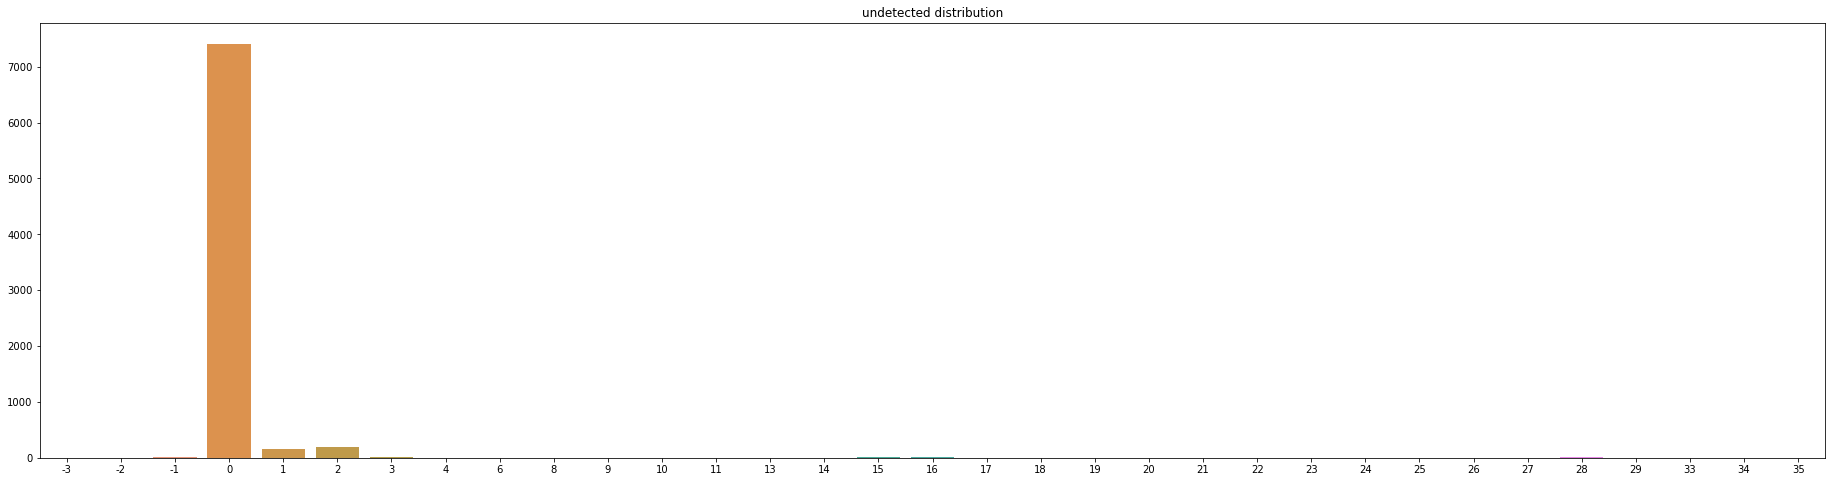

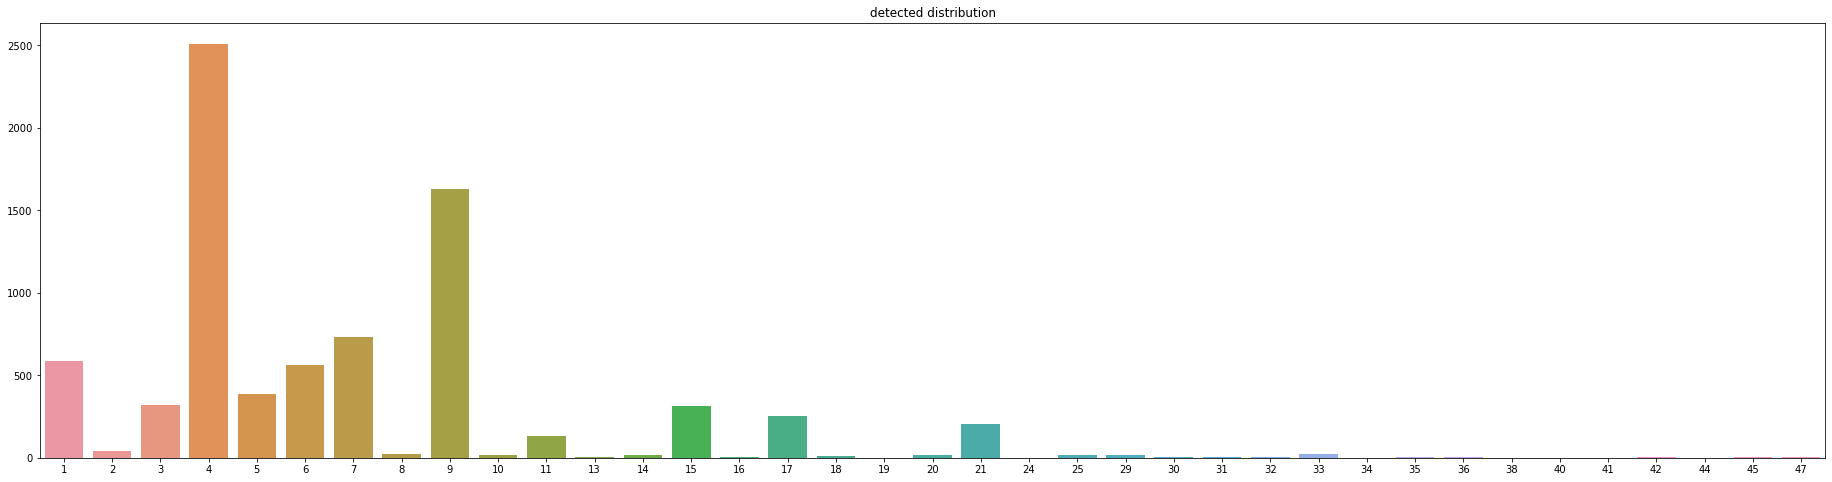

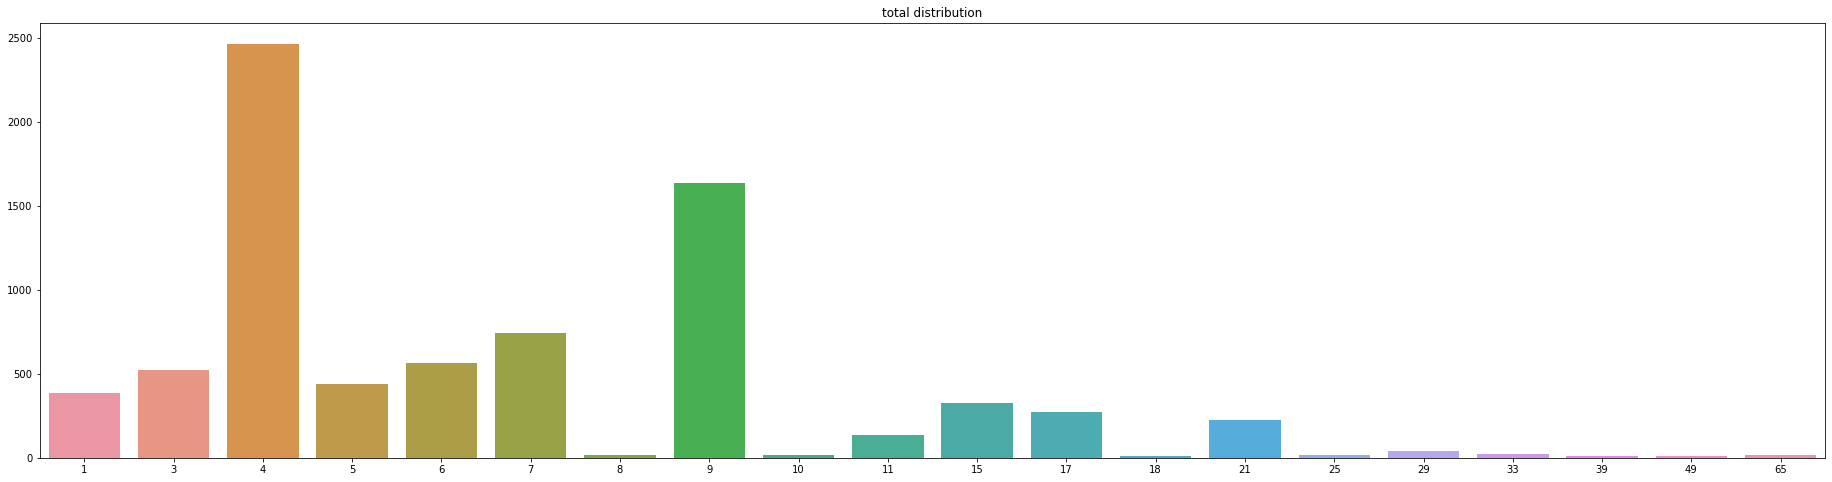

In [5]:
# Path
prediction_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/txt'
groundtruth_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/H_Dataset_03/Mixed/train_labels_lt_800_txt'
src_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/img'    
dst_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/train/temp'    

pin_statistics = compare_gt_and_prediction(prediction_txt_dir, groundtruth_txt_dir, src_img_dir, dst_img_dir)   
pin_statistics.to_csv("Train_PredictionPin_Statistics.csv", index=False)

### Test Dataset Evaluation

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:17<00:00, 24.79it/s]


undetected distribution ------------------
undetected
-1       2
 0     425
 1      12
 2       3
 16      1
 18      1
 23      1
Name: undetected, dtype: int64
detected distribution ------------------
detected
1      35
2      10
3      25
4     175
5      13
6      29
7      33
9      73
11      7
13      1
15     17
17     15
20      2
21      6
33      2
42      1
47      1
Name: detected, dtype: int64
total distribution ------------------
total
1      32
3      40
4     173
5      13
6      29
7      33
9      73
11      7
15     17
17     15
21      8
29      1
33      2
65      2
Name: total, dtype: int64


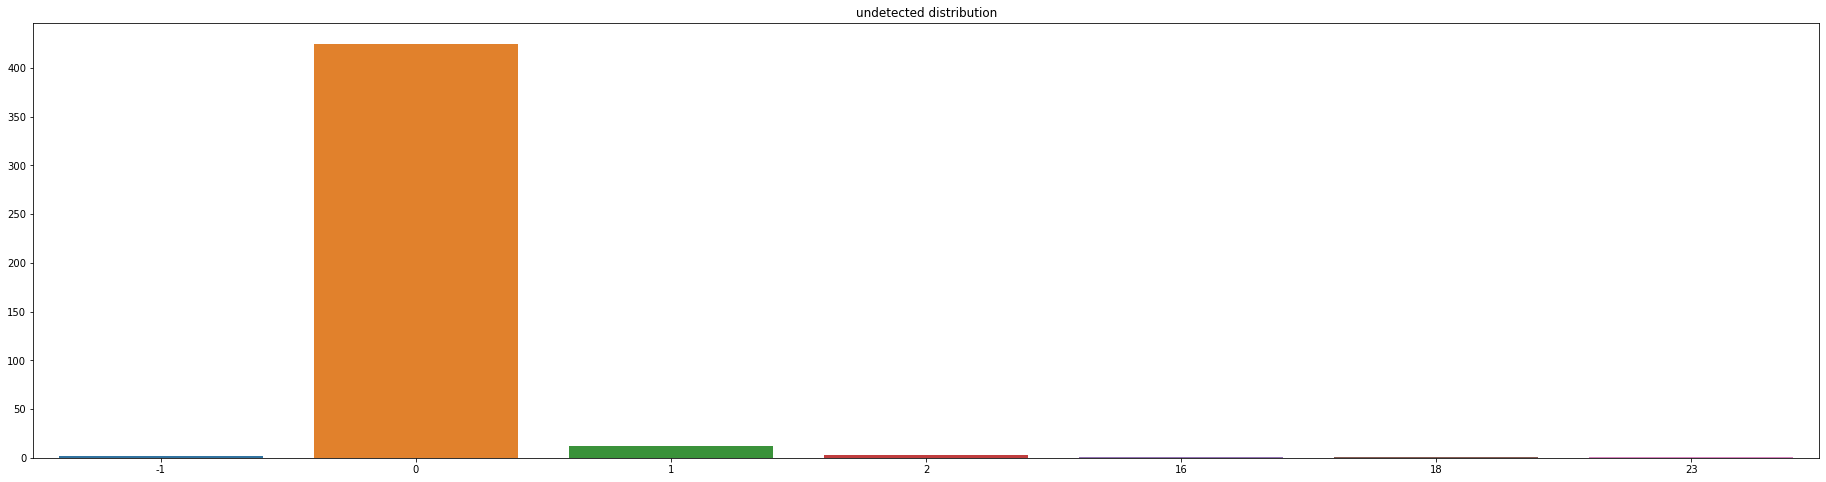

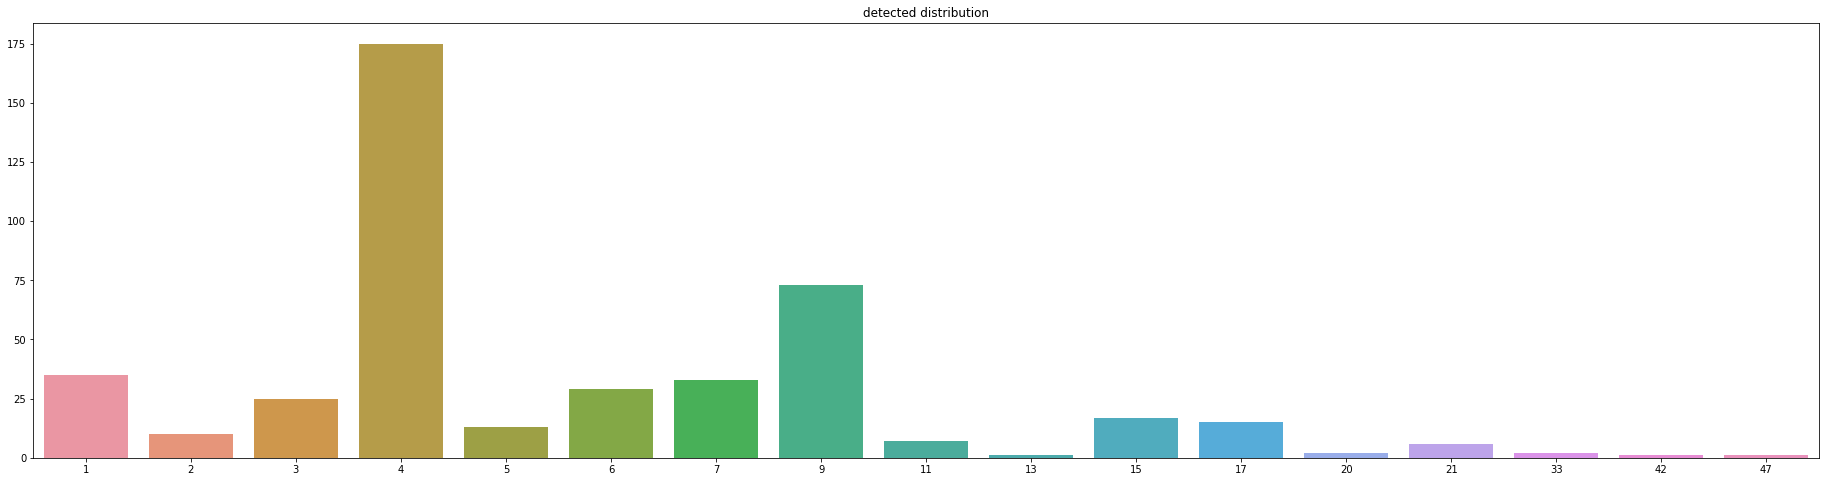

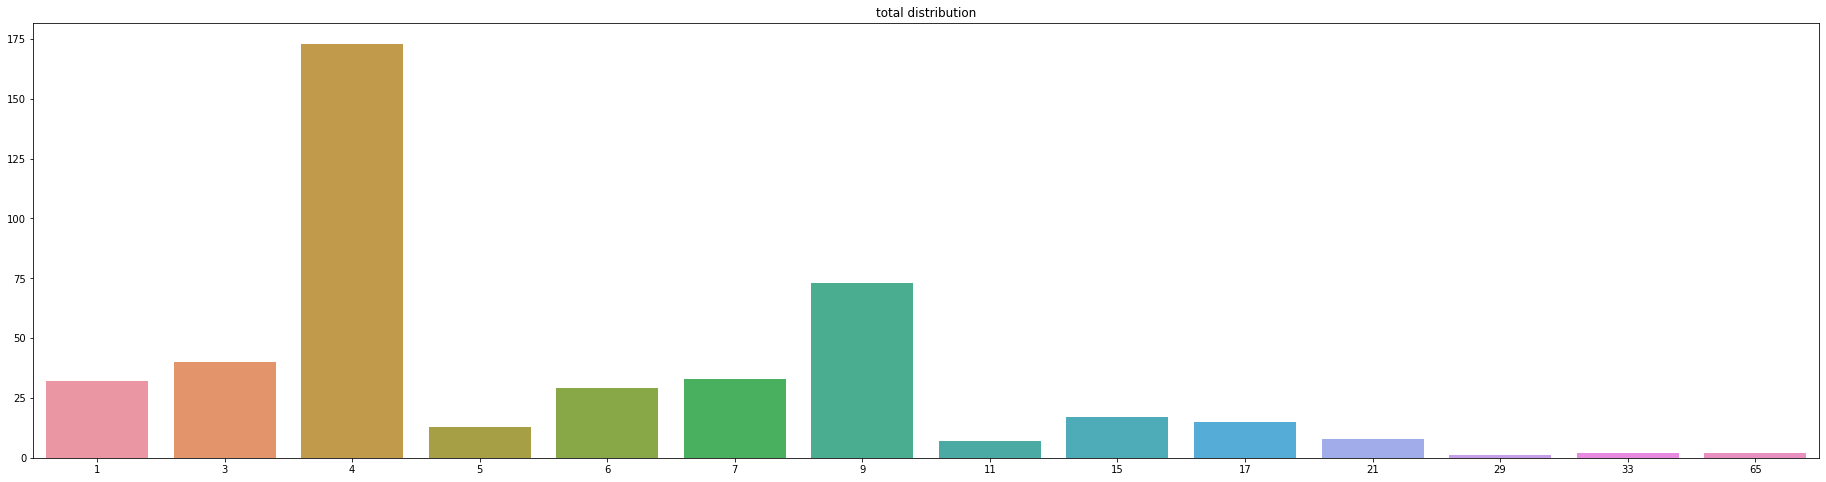

In [6]:
# Path
prediction_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/test/txt'
groundtruth_txt_dir ='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/images/H_Dataset_03/Mixed/test_labels_lt_800_txt'
src_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/test/img'    
dst_img_dir='D:/FZ_WS/JyNB/TF_Research_Api_LD_2_0/research/object_detection/debug/images_out-V-13-gekochtes-25k/test/temp'    

pin_statistics = compare_gt_and_prediction(prediction_txt_dir, groundtruth_txt_dir, src_img_dir, dst_img_dir)   
pin_statistics.to_csv("Test_PredictionPin_Statistics.csv", index=False)